In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import itertools
from mpl_toolkits.axes_grid1 import ImageGrid
import matplotlib.colors as colors
from sklearn.metrics import multilabel_confusion_matrix, confusion_matrix, ConfusionMatrixDisplay

In [3]:
true_lbls = ['PWR\nTrue', 'BWR\nTrue', 'PHWR\nTrue']
pred_lbls = ['PWR\nPredicted', 'BWR\nPredicted', 'PHWR\nPredicted']

def annotate_heatmap(im, nums, threshold=(-0.3, 0.3), textcolors=('white', 'black', 'white'), **textkw):
    
    #threshold = (-0.2, 0.2)
    #threshold = (-0.07, 0.07)
    data = im.get_array()
    
    kw = dict(size=14, #fontweight="bold", 
              horizontalalignment='center', verticalalignment='center')
    kw.update(textkw)
    
    fracfmt = matplotlib.ticker.StrMethodFormatter('{x:.3f}')
    diagfmt = matplotlib.ticker.StrMethodFormatter('({x:.3f})')
    numfmt = matplotlib.ticker.StrMethodFormatter('{x:.0f}')
    
    # Change the text's color depending on the data.
    texts = []
    for i in range(data.shape[0]):
        for j in range(data.shape[1]):
            if data[i, j] <= threshold[0]: #im.norm(data[i, j])
                tc_idx = 0
            elif data[i, j] >= threshold[1]: #im.norm(data[i, j])
                tc_idx = 2
            else:
                tc_idx = 1
            kw.update(color=textcolors[tc_idx])
            if i == j:
                pixeltexts = fracfmt(data[i, j]+1, None) + '\n' +  diagfmt(data[i, j], None) +'\n' + numfmt(nums[i, j], None)
            else:
                pixeltexts = fracfmt(data[i, j], None) + '\n' + numfmt(nums[i, j], None)
            text = im.axes.text(j, i, pixeltexts, **kw)
            texts.append(text)

    return texts

In [4]:
def im_cm(data, true_lbls, col_labels, last_row, ax, cbar_kw={}, **kwargs):
    im = ax.imshow(data, vmin=-1, vmax=1, **kwargs)
    #im = ax.imshow(data, vmin=-0.3, vmax=0.3, **kwargs)
    ax.set_yticks(np.arange(data.shape[0]))
    ax.set_yticklabels(true_lbls)
    ax.tick_params(labelsize=14)
    if last_row == True:
        ax.set_xticks(np.arange(data.shape[1]))
        ax.set_xticklabels(col_labels)
        ax.tick_params(top=False, bottom=True, labelsize=14, labeltop=False, labelbottom=True)
    # draw a grid
    ax.set_yticks(np.arange(data.shape[0]+1)-.5, minor=True)
    ax.set_xticks(np.arange(data.shape[1]+1)-.5, minor=True)
    ax.grid(which='minor', color='w', linestyle='-', linewidth=6)
    ax.tick_params(which='minor', bottom=False, left=False)
    return im


def plot_cm(alg_cms, cm_nums, row_labels):
    plt.clf()
    titles = ['kNN', 'Decision Trees', 'MLL Calcs']
    nrows = len(alg_cms)
    fig, axs = plt.subplots(nrows=nrows, ncols=3, sharex=True, sharey=True, figsize=(15,5*nrows))
    
    for row, ax_row in enumerate(axs):
        ax_row[0].set_ylabel(row_labels[row], fontsize=16)
        if row == nrows-1:
            last_row = True
            #ax_row[1].set_xlabel('Predicted label', fontsize=16, labelpad=10)
        else:
            last_row = False
        for col, ax in enumerate(ax_row):
            if row == 0:
                ax.set_title(titles[col], fontsize=18, pad=15)
            
            #cmap = matplotlib.cm.twilight
            #bounds = list(np.linspace(0.2, 0.8, 100))
            #bounds = list(np.linspace(0.01, 0.99, 100))
            #bounds = list(np.linspace(0.0, 1.0, 100))
            #norm = colors.BoundaryNorm(bounds, cmap.N, extend='both')
            #im = im_cm(alg_cms[row][col], true_lbls, pred_lbls, last_row, ax=ax, cmap=cmap, norm=norm)
            
            im = im_cm(alg_cms[row][col], true_lbls, pred_lbls, last_row, ax=ax, cmap='BrBG')
            texts = annotate_heatmap(im, cm_nums[row][col])
    
    plt.subplots_adjust(wspace=0.05, hspace=0.05)
    cax = fig.add_axes([0.915, 0.125, 0.03, 0.75])
    fig.colorbar(im, cax=cax)
    cax.tick_params(labelsize=14)
    plt.show()
    return fig

# Confusion Matrix for Reactor Type Results

### sfcompo

In [6]:
rdrive = '/mnt/researchdrive/BOX_INTERNAL/opotowsky/'
results_dir = rdrive + 'processed_results/'
mll_gam = rdrive + 'mll/gam_spec/'
mll_nuc = rdrive + 'mll/nuc_conc/'
learn_gam = rdrive + 'scikit/gam_spec/'
learn_nuc = rdrive + 'scikit/nuc_conc/'
pred = ['reactor', 'burnup', 'enrichment', 'cooling']
predmll = ['ReactorType', 'Burnup', 'Enrichment', 'CoolingTime']
cm_labels = ['pwr', 'bwr', 'phwr']

In [71]:
mll = pd.read_csv(mll_nuc + 'sfco/Job0_unc0.01_impnull/Job0_unc0.01_impnull.csv')
knn = pd.read_csv(learn_nuc + 'sfco/reactor_knn_tset1.0_nuc29_impnull_ext_test_compare.csv')
dtr = pd.read_csv(learn_nuc + 'sfco/reactor_dtree_tset1.0_nuc29_impnull_ext_test_compare.csv')

In [72]:
mll_0 = pd.read_csv(mll_nuc + 'sfco/Job1_unc0.01_0null/Job1_unc0.01_0null.csv')
knn_0 = pd.read_csv(learn_nuc + 'sfco/reactor_knn_tset1.0_nuc29_0null_ext_test_compare.csv')
dtr_0 = pd.read_csv(learn_nuc + 'sfco/reactor_dtree_tset1.0_nuc29_0null_ext_test_compare.csv')

In [76]:
mll_cm = confusion_matrix(mll[predmll[0]], mll['pred_' + predmll[0]], labels=cm_labels, normalize='true')
mll_cm_nums = confusion_matrix(mll[predmll[0]], mll['pred_' + predmll[0]], labels=cm_labels)
knn_cm = confusion_matrix(knn['TrueY'], knn['kNN'], labels=cm_labels, normalize='true')
knn_cm_nums = confusion_matrix(knn['TrueY'], knn['kNN'], labels=cm_labels)
dtr_cm = confusion_matrix(dtr['TrueY'], dtr['DTree'], labels=cm_labels, normalize='true')
dtr_cm_nums = confusion_matrix(dtr['TrueY'], dtr['DTree'], labels=cm_labels)
cm_list = [knn_cm, dtr_cm, mll_cm]
cmnums = [knn_cm_nums, dtr_cm_nums, mll_cm_nums]

mll_cm0 = confusion_matrix(mll_0[predmll[0]], mll_0['pred_' + predmll[0]], labels=cm_labels, normalize='true')
mll_cm_nums0 = confusion_matrix(mll_0[predmll[0]], mll_0['pred_' + predmll[0]], labels=cm_labels)
knn_cm0 = confusion_matrix(knn_0['TrueY'], knn_0['kNN'], labels=cm_labels, normalize='true')
knn_cm_nums0 = confusion_matrix(knn_0['TrueY'], knn_0['kNN'], labels=cm_labels)
dtr_cm0 = confusion_matrix(dtr_0['TrueY'], dtr_0['DTree'], labels=cm_labels, normalize='true')
dtr_cm_nums0 = confusion_matrix(dtr_0['TrueY'], dtr_0['DTree'], labels=cm_labels)
cm_list0 = [knn_cm0, dtr_cm0, mll_cm0]
cmnums0 = [knn_cm_nums0, dtr_cm_nums0, mll_cm_nums0]

cms = [cm_list, cm_list0]
for cml in cms:
    for cm in cml: 
        np.fill_diagonal(cm, np.diagonal(cm) - 1)
cm_nums = [cmnums, cmnums0]

<Figure size 432x288 with 0 Axes>

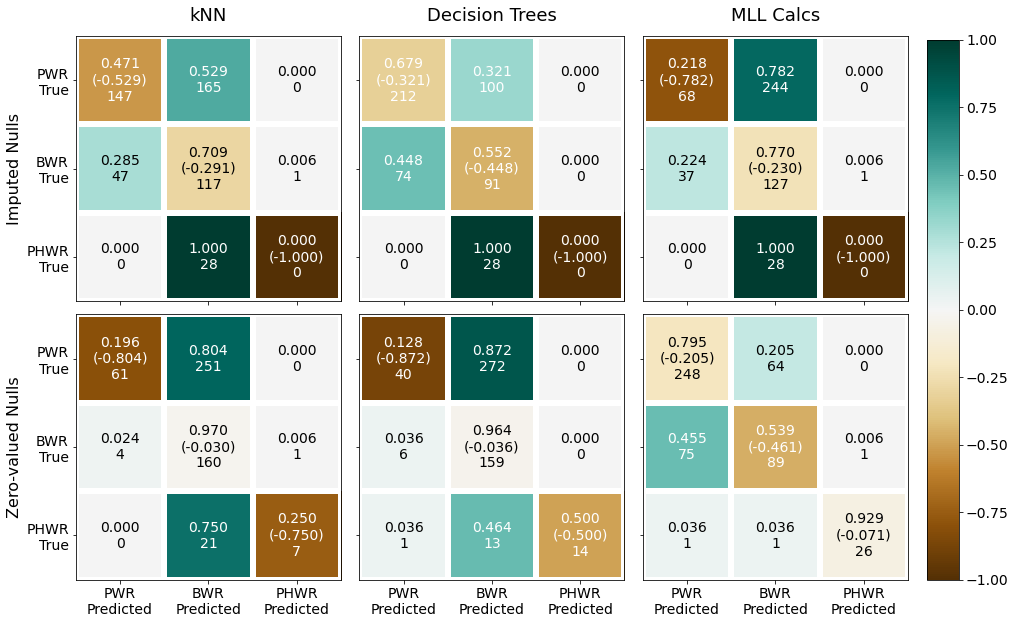

In [77]:
row_labels = ['Imputed Nulls', 'Zero-valued Nulls']
fig = plot_cm(cms, cm_nums, row_labels)
sv_fig = './plots/confusion_matrix_sfco.png'
fig.savefig(sv_fig, bbox_inches='tight', transparent=True)

### nuc29, 1%, 10%, 20% error cases

In [17]:
mll0 = pd.read_csv(mll_nuc + 'nuc29/Job0_unc0.01/Job0_unc0.01.csv')
knn0 = pd.read_csv(learn_nuc + 'cv_pred/cv5/nuc29/reactor_knn_tset1.0_nuc29_predictions.csv')
dtr0 = pd.read_csv(learn_nuc + 'cv_pred/cv5/nuc29/reactor_dtree_tset1.0_nuc29_predictions.csv')

mll1 = pd.read_csv(mll_nuc + 'nuc29/Job2_unc0.1/Job2_unc0.1.csv')
knn1 = pd.read_csv(learn_nuc + 'rand_err/reactor_knn_tset1.0_nuc29_err10_random_error.csv')
dtr1 = pd.read_csv(learn_nuc + 'rand_err/reactor_dtree_tset1.0_nuc29_err10_random_error.csv')

mll2 = pd.read_csv(mll_nuc + 'nuc29/Job4_unc0.2/Job4_unc0.2.csv')
knn2 = pd.read_csv(learn_nuc + 'rand_err/reactor_knn_tset1.0_nuc29_err20_random_error.csv')
dtr2 = pd.read_csv(learn_nuc + 'rand_err/reactor_dtree_tset1.0_nuc29_err20_random_error.csv')

In [65]:
mll_cm0 = confusion_matrix(mll0[predmll[0]], mll0['pred_' + predmll[0]], labels=cm_labels, normalize='true')
mll_cm_nums0 = confusion_matrix(mll0[predmll[0]], mll0['pred_' + predmll[0]], labels=cm_labels)
knn_cm0 = confusion_matrix(knn0['TrueY'], knn0['kNN'], labels=cm_labels, normalize='true')
knn_cm_nums0 = confusion_matrix(knn0['TrueY'], knn0['kNN'], labels=cm_labels)
dtr_cm0 = confusion_matrix(dtr0['TrueY'], dtr0['DTree'], labels=cm_labels, normalize='true')
dtr_cm_nums0 = confusion_matrix(dtr0['TrueY'], dtr0['DTree'], labels=cm_labels)
cm_list0 = [knn_cm0, dtr_cm0, mll_cm0]
cmnums0 = [knn_cm_nums0, dtr_cm_nums0, mll_cm_nums0]

In [66]:
mll_cm1 = confusion_matrix(mll1[predmll[0]], mll1['pred_' + predmll[0]], labels=cm_labels, normalize='true')
mll_cm_nums1 = confusion_matrix(mll1[predmll[0]], mll1['pred_' + predmll[0]], labels=cm_labels)
knn_cm1 = confusion_matrix(knn1['TrueY'], knn1['kNN'], labels=cm_labels, normalize='true')
knn_cm_nums1 = confusion_matrix(knn1['TrueY'], knn1['kNN'], labels=cm_labels)
dtr_cm1 = confusion_matrix(dtr1['TrueY'], dtr1['DTree'], labels=cm_labels, normalize='true')
dtr_cm_nums1 = confusion_matrix(dtr1['TrueY'], dtr1['DTree'], labels=cm_labels)
cm_list1 = [knn_cm1, dtr_cm1, mll_cm1]
cmnums1 = [knn_cm_nums1, dtr_cm_nums1, mll_cm_nums1]

In [67]:
mll_cm2 = confusion_matrix(mll2[predmll[0]], mll2['pred_' + predmll[0]], labels=cm_labels, normalize='true')
mll_cm_nums2 = confusion_matrix(mll2[predmll[0]], mll2['pred_' + predmll[0]], labels=cm_labels)
knn_cm2 = confusion_matrix(knn2['TrueY'], knn2['kNN'], labels=cm_labels, normalize='true')
knn_cm_nums2 = confusion_matrix(knn2['TrueY'], knn2['kNN'], labels=cm_labels)
dtr_cm2 = confusion_matrix(dtr2['TrueY'], dtr2['DTree'], labels=cm_labels, normalize='true')
dtr_cm_nums2 = confusion_matrix(dtr2['TrueY'], dtr2['DTree'], labels=cm_labels)
cm_list2 = [knn_cm2, dtr_cm2, mll_cm2]
cmnums2 = [knn_cm_nums2, dtr_cm_nums2, mll_cm_nums2]

<Figure size 432x288 with 0 Axes>

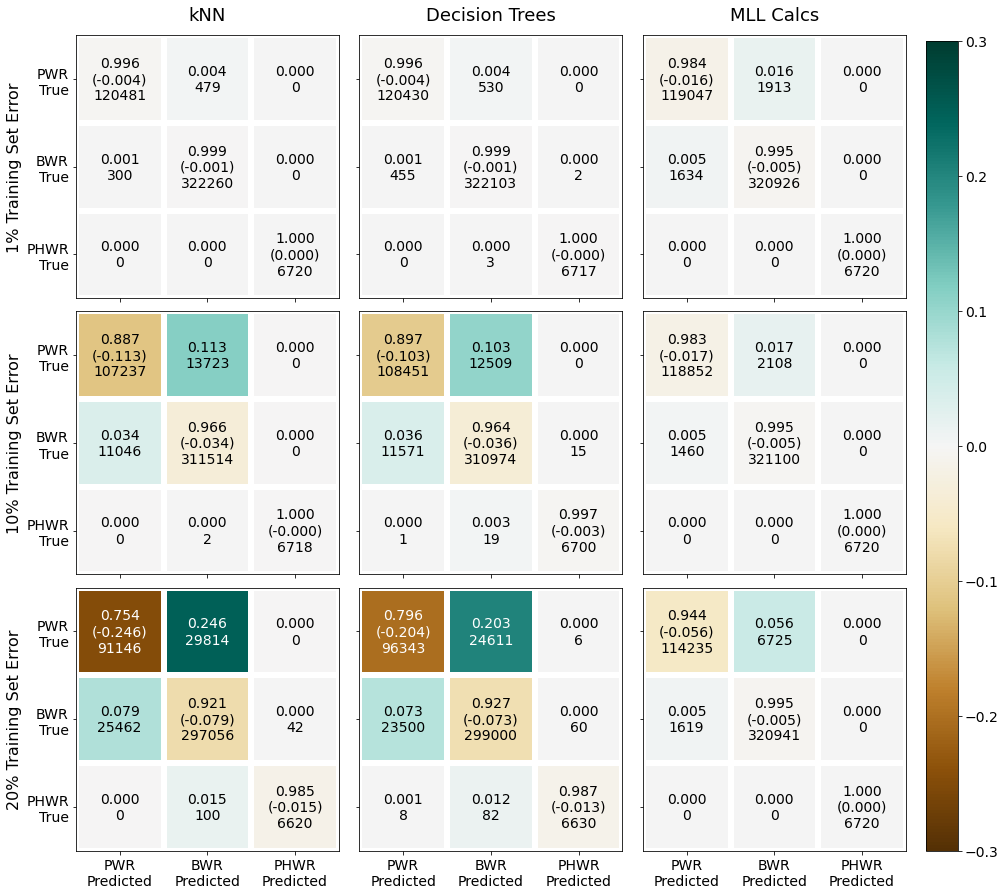

In [68]:
cms = [cm_list0, cm_list1, cm_list2]
cm_nums = [cmnums0, cmnums1, cmnums2]

for cml in cms:
    for cm in cml: 
        np.fill_diagonal(cm, np.diagonal(cm) - 1)

row_labels = ['1% Training Set Error', '10% Training Set Error', '20% Training Set Error']
fig = plot_cm(cms, cm_nums, row_labels)
sv_fig = './plots/confusion_matrix_nuc29_3errs.png'
fig.savefig(sv_fig, bbox_inches='tight', transparent=True)

## conf matrices for ch 4

In [19]:
import pickle
res_dir = '/mnt/researchdrive/BOX_INTERNAL/opotowsky/processed_results/'
pklname = res_dir + 'confusion_matrices_all_detectors_normalized.pkl'
with open(pklname, 'rb') as pkl:
    cm_norm = pickle.load(pkl)
pklname = res_dir + 'confusion_matrices_all_detectors_rawnums.pkl'
with open(pklname, 'rb') as pkl:
    cm_num = pickle.load(pkl)

In [6]:
Nucs = ['29 Nuclide Masses', '32 Nuclide Activities', '12 Nuclide Activities', '7 Nuclide Activities']
dets = ['d1_hpge', 'd2_hpge', 'd3_czt', 'd6_sri2', 'd5_labr3', 'd4_nai']
Dets = ['Lab HPGe', 'Portable HPGe', 'CZT', 'SrI2', 'LaBr3', 'NaI']
ens = ['auto', 'short', 'long']
algs = ['knn', 'dtree', 'mll']

### nuc/acts only (non-enlist dependent)

<Figure size 432x288 with 0 Axes>

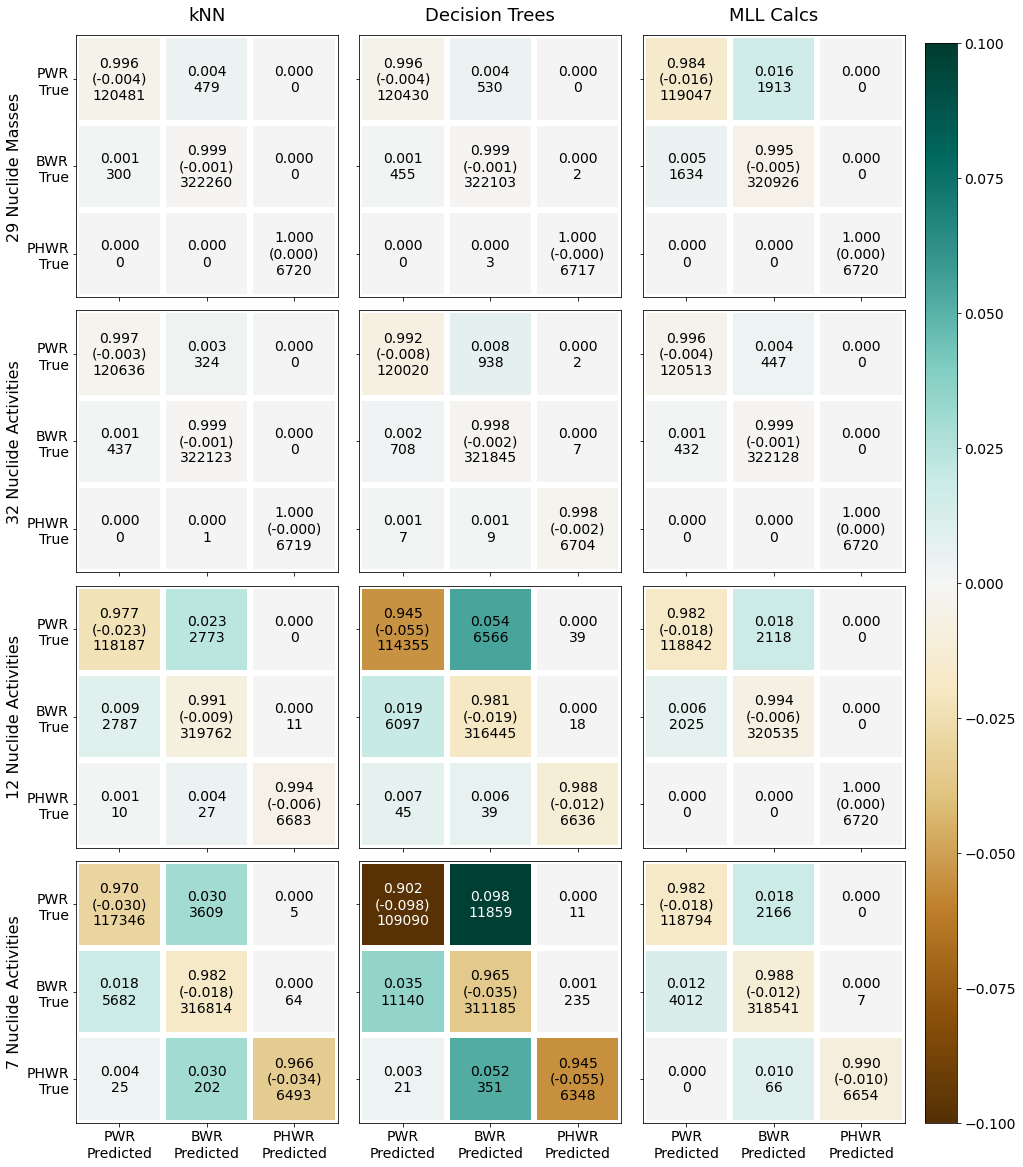

In [52]:
cms = [cm_norm['nuc29']['short'], 
       cm_norm['act32']['short'], 
       cm_norm['act7/12']['long'], 
       cm_norm['act7/12']['short']]
cm_nums = [cm_num['nuc29']['short'], 
           cm_num['act32']['short'], 
           cm_num['act7/12']['long'], 
           cm_num['act7/12']['short']]
row_labels = Nucs

for cml in cms:
    for cm in cml: 
        np.fill_diagonal(cm, np.diagonal(cm) - 1)

fig = plot_cm(cms, cm_nums, row_labels)
sv_fig = './plots/confusion_matrix_nucs_acts.png'
fig.savefig(sv_fig, bbox_inches='tight', transparent=True)

### en list dependent dets

### Attempting larger grid:

In [20]:
true_lbls = ['PWR\nTrue', 'BWR\nTrue', 'PHWR\nTrue']
pred_lbls = ['PWR\nPred', 'BWR\nPred', 'PHWR\nPred']

def annotate_heatmap(im, nums, threshold=(-0.35, 0.35), textcolors=('white', 'black', 'white'), **textkw):
    
    data = im.get_array()
    
    kw = dict(size=11, #fontweight="bold", 
              horizontalalignment='center', verticalalignment='center')
    kw.update(textkw)
    
    fracfmt = matplotlib.ticker.StrMethodFormatter('{x:.3f}')
    diagfmt = matplotlib.ticker.StrMethodFormatter('({x:.3f})')
    numfmt = matplotlib.ticker.StrMethodFormatter('{x:.0f}')
    
    # Change the text's color depending on the data.
    texts = []
    for i in range(data.shape[0]):
        for j in range(data.shape[1]):
            if data[i, j] <= threshold[0]:
                tc_idx = 0
            elif data[i, j] >= threshold[1]:
                tc_idx = 2
            else:
                tc_idx = 1
            kw.update(color=textcolors[tc_idx])
            if i == j:
                pixeltexts = fracfmt(data[i, j]+1, None) + '\n' +  diagfmt(data[i, j], None) +'\n' + numfmt(nums[i, j], None)
            else:
                pixeltexts = fracfmt(data[i, j], None) + '\n' + numfmt(nums[i, j], None)
            text = im.axes.text(j, i, pixeltexts, **kw)
            texts.append(text)

    return texts

def im_cm(data, true_lbls, col_labels, last_row, ax, cbar_kw={}, **kwargs):
    im = ax.imshow(data, vmin=-0.65, vmax=0.65, **kwargs)
    ax.set_yticks(np.arange(data.shape[0]))
    ax.set_yticklabels(true_lbls)
    ax.tick_params(labelsize=14)
    if last_row == True:
        ax.set_xticks(np.arange(data.shape[1]))
        ax.set_xticklabels(col_labels)
        ax.tick_params(top=False, bottom=True, labelsize=14, labeltop=False, labelbottom=True)
    # draw a grid
    ax.set_yticks(np.arange(data.shape[0]+1)-.5, minor=True)
    ax.set_xticks(np.arange(data.shape[1]+1)-.5, minor=True)
    ax.grid(which='minor', color='w', linestyle='-', linewidth=5)
    ax.tick_params(which='minor', bottom=False, left=False)
    return im

def plot_big_cm(alg_cms, cm_nums, row_labels):
    plt.clf()
    titles = ['kNN', 'Decision Trees', 'MLL Calcs']
    nrows = len(alg_cms)
    fig, axs = plt.subplots(nrows=nrows, ncols=3, sharex=True, sharey=True, figsize=(10,3.3*nrows))
    
    for row, ax_row in enumerate(axs):
        ax_row[0].set_ylabel(row_labels[row], fontsize=16)
        if row == nrows-1:
            last_row = True
            #ax_row[1].set_xlabel('Predicted label', fontsize=16, labelpad=10)
        else:
            last_row = False
        for col, ax in enumerate(ax_row):
            if row == 0:
                ax.set_title(titles[col], fontsize=18, pad=15)
                
            #cmap = matplotlib.cm.twilight
            #bounds = list(np.linspace(0.1, 0.9, 100))
            #norm = colors.BoundaryNorm(bounds, cmap.N, extend='both')            
            #im = im_cm(alg_cms[row][col], true_lbls, pred_lbls, last_row, ax=ax, cmap=cmap, norm=norm)
            
            im = im_cm(alg_cms[row][col], true_lbls, pred_lbls, last_row, ax=ax, cmap='BrBG')
            texts = annotate_heatmap(im, cm_nums[row][col])
    
    plt.subplots_adjust(wspace=0.05, hspace=0.05)
    cax = fig.add_axes([0.915, 0.125, 0.03, 0.75])
    fig.colorbar(im, cax=cax)
    cax.tick_params(labelsize=14)
    plt.show()
    return fig

<Figure size 432x288 with 0 Axes>

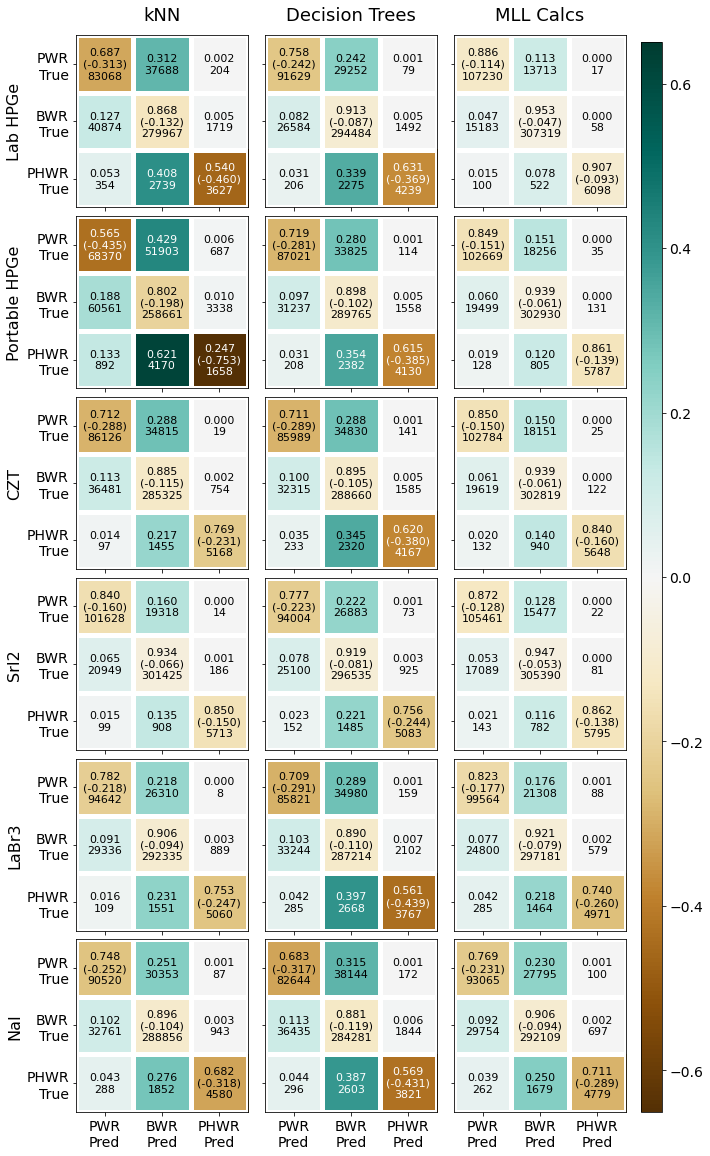

<Figure size 432x288 with 0 Axes>

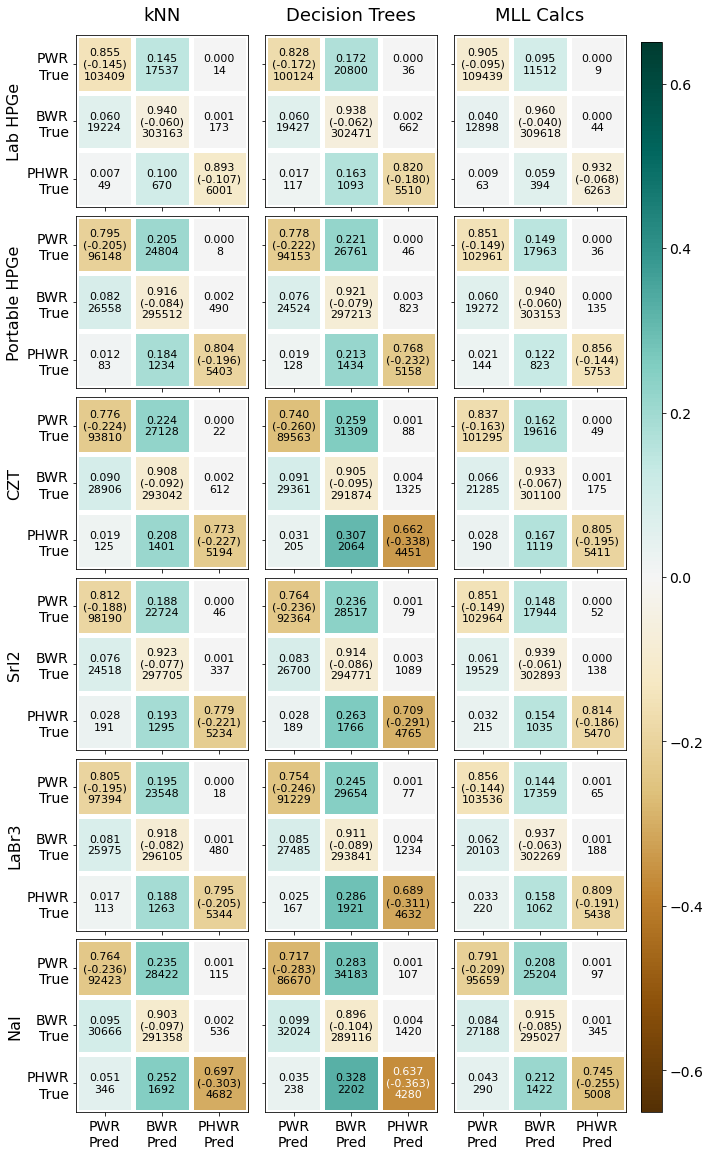

<Figure size 432x288 with 0 Axes>

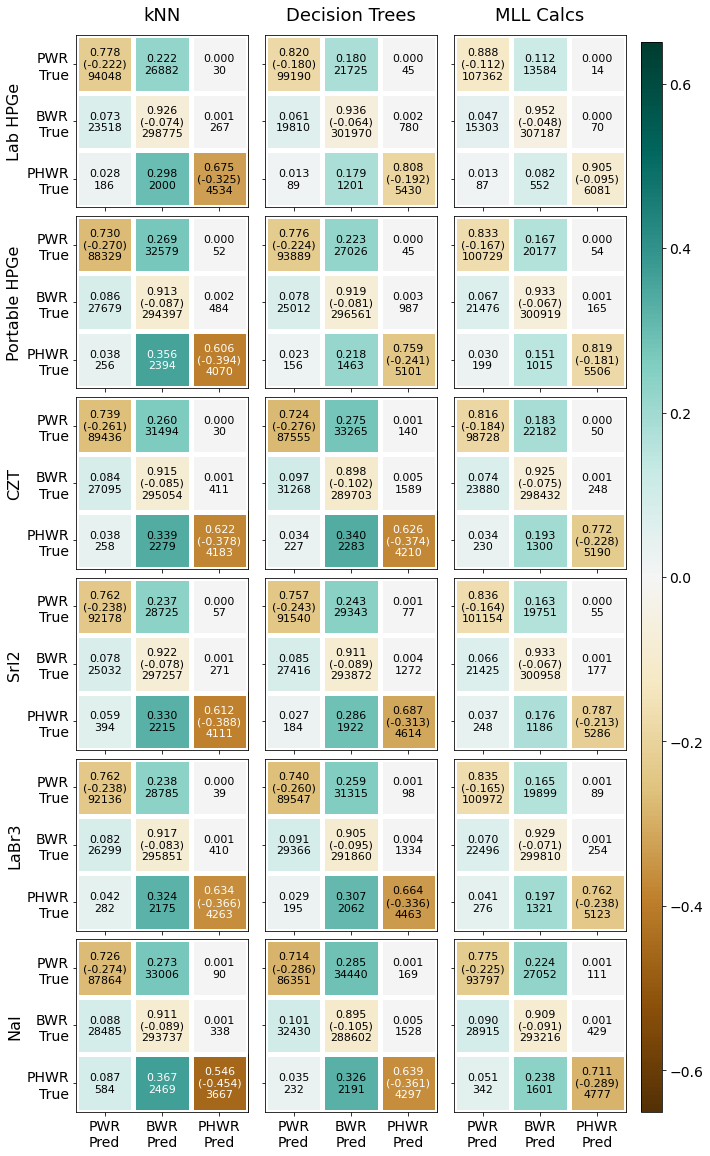

In [21]:
for en in ens:
    cms = []
    cm_nums = []
    for det in dets[0:6]:
        cms.append(cm_norm[det][en])
        cm_nums.append(cm_num[det][en])
    row_labels = Dets[0:6]
    
    for cml in cms:
        for cm in cml: 
            np.fill_diagonal(cm, np.diagonal(cm) - 1)
    
    fig = plot_big_cm(cms, cm_nums, row_labels)
    sv_fig = './plots/confusion_matrix_6dets_'+ en +'.png'
    fig.savefig(sv_fig, bbox_inches='tight', transparent=True)